In [1]:
import requests
import yfinance as yf
import pandas as pd
import random
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

c:\Users\Shane\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Import all necessary functions for evaluation

In [2]:
# Get Ticker Metadata
# ------------------------------------------------------------------
FINNHUB_API_KEY = 'cuaq7shr01qof06j5bfgcuaq7shr01qof06j5bg0'
EXCHANGE_CODE = 'US' 

url = f'https://finnhub.io/api/v1/stock/symbol?exchange={EXCHANGE_CODE}&token={FINNHUB_API_KEY}'

try:
    response = requests.get(url)
    response.raise_for_status()  # Raise an exception for bad status codes
    tickers_data = response.json()

    # Extract ticker symbols from the response
    tickers = [item['symbol'] for item in tickers_data] 

    print(tickers)

except requests.exceptions.RequestException as e:
    print(f"-- Error fetching data: {e} --")

['CHR', 'STSR', 'NEXXY', 'MLKKF', 'HWDJF', 'IPOAF', 'SLG', 'QLTY', 'CRSXQ', 'UTNDF', 'BANC', 'SGPPY', 'NEOG', 'CETY', 'PROK', 'CTTAY', 'OCLN', 'CANC', 'QOIL', 'ANGH', 'BAC.PRB', 'MEGEF', 'UBQU', 'GDMN', 'MNST', 'CPWPF', 'BTSDF', 'PPERF', 'IIVPF', 'CKSNY', 'RIGS', 'CYZN', 'TGOSY', 'LDP', 'FFSM', 'ACBD', 'TAOIF', 'ELP', 'FOXY', 'RNCHF', 'ADSEW', 'GGM', 'SMLL', 'LNXSF', 'MCBI', 'SDWHF', 'PNAGF', 'SOLLY', 'METU', 'BWEFF', 'ZKGCF', 'FSLR', 'IVUSF', 'ISRRF', 'FTGC', 'GLOP.PRC', 'MSTO', 'ZHEXF', 'SYBX', 'KLDI', 'KMPB', 'CYIO', 'AIMDW', 'CDR.PRC', 'COMM', 'ALFMF', 'PNI', 'ASNHF', 'WNDLF', 'BLUU', 'GCSSF', 'FMELF', 'CRZBY', 'BLHEF', 'TOST', 'VIPV', 'QBIG', 'ARDDF', 'IBUY', 'SPTM', 'CYGT', 'RESSS', 'SLAHF', 'KDEC', 'TATYF', 'BTTAY', 'IFNNF', 'CNLHP', 'EGP', 'FUST', 'DUO', 'PNST', 'ADVNF', 'IMSPF', 'MYCB', 'SYF', 'IFUS', 'BUFT', 'DJTGF', 'JIPCF', 'AANNF', 'EET', 'GORIF', 'MORT', 'DAVE', 'RUMBW', 'LEBGF', 'AMRC', 'PSTL', 'NORX', 'SUIFF', 'COSAF', 'AREC', 'IFMK', 'UBMRF', 'ANGHW', 'SMBZF', 'LAUR', 

In [3]:
def load_data(ticker):
    """
    Downloads historical market data for a given ticker symbol.

    Parameters:
    ticker (str): The ticker symbol of the stock to download data for.

    Returns:
    pd.DataFrame: A DataFrame containing the historical market data for the specified ticker.
    """
    data = yf.download(ticker, period='max') # returns relevant data in df
    data.reset_index(inplace=True) # reset multindex, output is index list of tuples
    cols = list(data.columns) # convert index to list
    cols[0] = ('Date', '') 
    cols = [i[0] for i in cols] # return first element of cols tuples
    data.columns = cols # set as column names
    data['Date'] = pd.to_datetime(data['Date']).dt.date
    return data

In [ ]:
# Create dict counter for samples across all volatility categories

category_ct_dict = {
    'Low': 0,
    'Medium-Low': 0,
    'Medium': 0,
    'Medium-High': 0,
    'High': 0
}

In [ ]:
def get_volatility(data):
    """
    Calculate the volatility of daily returns and categorize it into levels.

    This function computes the annualized volatility of daily returns from the input data.
    It then categorizes the volatility into one of five levels: "Low", "Medium-Low", "Medium", 
    "Medium-High", or "High" based on predefined thresholds.

    Parameters:
    data (DataFrame): A pandas DataFrame containing a 'daily_returns' column with daily return values.

    Returns:
    tuple: A tuple containing the volatility category (str) and the calculated volatility (float).
    """
    volatility = data.daily_returns.std() * np.sqrt(252)
    if volatility < 0.2:
        category = "Low"
    elif volatility < 0.4:
        category = "Medium-Low"
    elif volatility < 0.6:
        category = "Medium"
    elif volatility < 0.8:
        category = "Medium-High"
    else:
        category = "High"
    return category, volatility

In [ ]:
def get_period_params(data, volatility):
    """
    Determine the training, period unit, and forecast periods based on data length and volatility.

    This function calculates the appropriate training period, period unit, and forecast period 
    based on the length of the input data and the given volatility. If the data length is less 
    than 8 years, the period unit and forecast period are set to a quarter of the data length. 
    Otherwise, the period unit is set to 1 year, and the forecast period is set to 1 year. 
    The training period is adjusted based on the volatility.

    Parameters:
    data (DataFrame): A pandas DataFrame containing the data.
    volatility (float): The calculated annualized volatility.

    Returns:
    tuple: A tuple containing:
        - train_period (int): The length of the training period.
        - period_unit (int): The length of the period unit.
        - forecast_period (int): The length of the forecast period.
    """
    if len(data)/365 < 8:
        period_unit = int(len(data)/4)
        forecast_period = period_unit
        train_period = len(data)
    else:
        period_unit = 365
        forecast_period = period_unit
        train_period = forecast_period * 4 if volatility < 0.6 else forecast_period * 8
    return train_period, period_unit, forecast_period

In [ ]:
# Lambda function for performing cross-validation with specified parameters

cv_func = lambda model_name, train_period, period_unit, forecast_period: cross_validation(model_name, 
                                              initial=f'{train_period} days', 
                                              period=f'{period_unit} days', 
                                              horizon=f'{forecast_period} days', 
                                              parallel="processes")

In [8]:
len_tickers = len(tickers)

In [ ]:
def validity_check(data):
    """
    Validate the input data based on specific criteria.

    This function checks if the input data meets the following criteria:
    - The data must cover at least 1 year.
    - The average closing price must be at least $10.
    - The average trading volume over the last 20 days must be at least 100,000.

    Parameters:
    data (DataFrame): A pandas DataFrame containing the stock data with 'Close' and 'Volume' columns.

    Returns:
    bool: True if the data meets all the criteria, False otherwise.
    """
    return (len(data) > 365) \
        and (data.Close.mean() >= 10).item() \
            and (data['Volume'].rolling(window=20).mean().iloc[-1] >= 100000).item()

In [ ]:
def score_ticker_smapes():
    """
    Score and return SMAPE values for 150 relevant tickers.

    This function iterates through a list of tickers, downloads their historical data, 
    and validates the data based on specific criteria. For valid data, it calculates 
    the volatility and categorizes it. It then trains a Prophet model and performs 
    cross-validation to compute the SMAPE (Symmetric Mean Absolute Percentage Error) 
    for each ticker. The process continues until 30 tickers are modeled for each 
    volatility category.

    Returns:
    tuple: A tuple containing:
        - smapes (list): A list of SMAPE values for the modeled tickers.
        - tickers_modeled (list): A list of tickers that were successfully modeled.
        - volatility_list (list): A list of volatility categories for the modeled tickers.
        - avg_price_list (list): A list of average closing prices for the modeled tickers.
        - len_list (list): A list of data lengths for the modeled tickers.
    """
    smapes = []
    tickers_modeled = []
    volatility_list = []
    avg_price_list = []
    len_list = []
    while True:
        category, volatility = '', 0
        ticker_n = random.randint(0, len(tickers))
        ticker_to_model = tickers.pop(ticker_n) # .pop() ensures that the ticker is removed from the list
        data = yf.download(ticker_to_model, period='max')
        if validity_check(data):
            data = load_data(ticker_to_model)
        else:
            continue
        data['daily_returns'] = data.Close.pct_change()
        category, volatility = get_volatility(data)
        if category_ct_dict[category] < 30:
            tickers_modeled.append(ticker_to_model)
            volatility_list.append(category)
            avg_price_list.append(data.Close.mean())
            len_list.append(len(data))
            category_ct_dict[category] += 1
            train_period, period_unit, forecast_period = get_period_params(data, volatility)
            df_train = data[['Date', 'Close']].iloc[-train_period:]
            df_train.columns = ['ds', 'y']
            m = Prophet().fit(df_train)
            df_cv = cv_func(m, train_period, period_unit, forecast_period)
            df_p = performance_metrics(df_cv, rolling_window=1)
            smapes.append(df_p['smape'].values[0])
        if all(value >= 30 for value in category_ct_dict.values()):
            break 
    return smapes, tickers_modeled, volatility_list, avg_price_list, len_list

In [11]:
smapes, tickers_modeled, volatility_list, avg_price_list, len_list = score_ticker_smapes()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
# check category count

category_ct_dict

{'Low': 30, 'Medium-Low': 30, 'Medium': 30, 'Medium-High': 30, 'High': 30}

In [13]:
len(tickers_modeled)

150

In [14]:
len(smapes)

150

In [15]:
len(volatility_list)

150

In [16]:
df = pd.DataFrame({
    'ticker': tickers_modeled, 
    'volatility': volatility_list, 
    'smape': smapes, 
    'avg_price': avg_price_list, 
    'len': len_list
    })
df.head()

,ticker,volatility,smape,avg_price,len
0,WPP,Medium,0.270578,32.136355,9355
1,CVGW,Medium,0.162737,31.071787,5681
2,DFH,Medium,0.305700,22.145518,1023
3,RCEL,Medium-High,0.915579,13.289237,3209
4,C,Medium-Low,0.325752,79.326248,12132


In [17]:
df.volatility.value_counts()

volatility
Medium         30
Medium-High    30
Medium-Low     30
High           30
Low            30
Name: count, dtype: int64

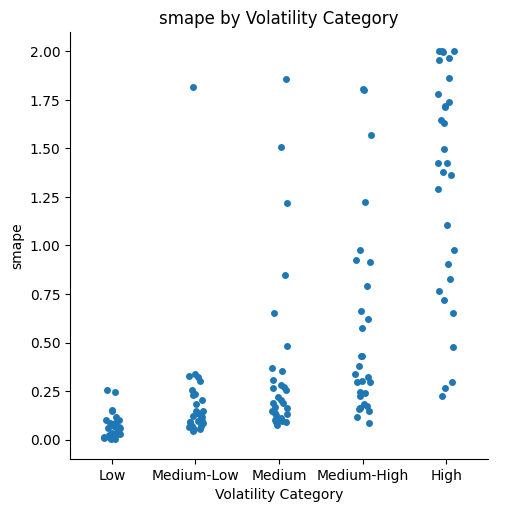

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

order = ['Low', 'Medium-Low', 'Medium', 'Medium-High', 'High'] 

# Create the catplot
sns.catplot(x='volatility', y='smape', data=df, kind='strip', order=order) 

# Customize the plot (optional)
plt.xlabel('Volatility Category')
plt.ylabel('smape')
plt.title('smape by Volatility Category')

# Show the plot
plt.show()

In [19]:
high_volatility = df[df['volatility'] == 'High']
high_volatility.sort_values('smape', ascending=False)

,ticker,volatility,smape,avg_price,len
18,STBX,High,2.000000,2.270361e+01,623
71,MSPR,High,2.000000,2.506373e+03,1085
94,JAGX,High,1.999787,6.732783e+06,2457
69,UPXI,High,1.996495,5.660678e+01,916
105,ACB,High,1.965121,2.201506e+02,2665
60,MJLB,High,1.954424,1.371985e+05,6891
93,MIGI,High,1.861156,2.250530e+03,3266
48,EZGO,High,1.780370,6.023215e+01,1020
85,OCGN,High,1.737462,8.340441e+01,2566
49,FGEN,High,1.716516,2.643918e+01,2578


In [20]:
filtered_df = df[df['volatility'] != 'High']
filtered_df.volatility.value_counts()

volatility
Medium         30
Medium-High    30
Medium-Low     30
Low            30
Name: count, dtype: int64

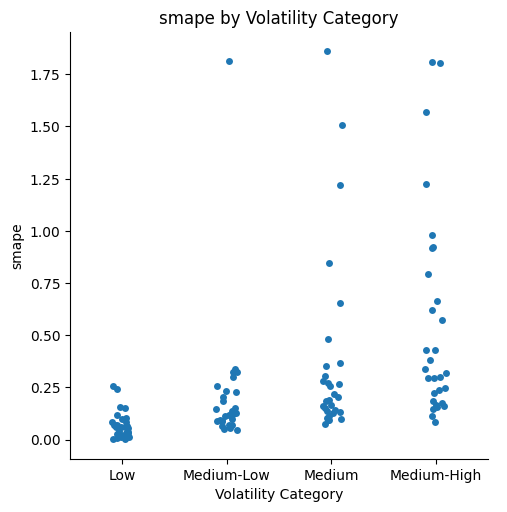

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

order = ['Low', 'Medium-Low', 'Medium', 'Medium-High'] 

# Create the catplot
sns.catplot(x='volatility', y='smape', data=filtered_df, kind='strip', order=order) 

# Customize the plot (optional)
plt.xlabel('Volatility Category')
plt.ylabel('smape')
plt.title('smape by Volatility Category')

# Show the plot
plt.show()

In [22]:
# save data manually to csv

standard_model_path = r"C:\Users\Shane\Desktop\2024.06.27_-_Data_Science\2024.10.13 - Portfolio Projects\2024.12.04 - Swing Ticker\SMAPE Model Eval"

In [23]:
df.to_csv(standard_model_path + r"\standard_model.csv", index=False)